# Knowledge Improvement analysis
In this anaysis, we study the impact of the use of the didactalia and the AFEL application on the knowledge improvement.

# Import & Constants

In [1]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr

## Here are the constants you might want to change !

In [2]:
FUSEKI_DATASET = "evalafel2" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX sch: <http://schema.org/>
    
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Data Retrieval

In [5]:
def sparql_to_dataframe(query):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio)
    finally:
        del res
        gc.collect()

In [6]:
def get_knowledge_cognitive_tests():
    query = SPARQL_PREFIX + """
    SELECT ?username ?questionID ?ratingValue ?time
    WHERE { 
      $action a sch:ChooseAction .
      $action sch:endTime ?time .
      $action sch:actionOption $rating .
      $rating sch:ratingValue ?ratingValue .
      $action sch:object $question .
      $question sch:identifier ?questionID .
      $question sch:isPartOf $questionnaire .
      $rating sch:author $user .
      $user afl:userName ?username .
      FILTER regex(?questionID, "^AFEL_2_KNOW") .
    }
    """
    return sparql_to_dataframe(query)

In [7]:
def get_user_activities_counts(min_date, max_date):
    query = SPARQL_PREFIX + """
    SELECT ?username ?activityType ?location (COUNT(?time) AS ?count)
    WHERE {
        $activity rdf:type ?activityType .
        $activity afl:user $user .
        $activity afl:eventEndDate ?time .
        $activity sch:location ?location .
        $user afl:userName ?username .
        FILTER(?activityType IN (afl:ArtifactView, extafl:DidactaliaGamePlayed, extafl:Search, extafl:RecommendedActivityView)) .
        FILTER(?time >= "%s"^^xsd:dateTime && ?time <= "%s"^^xsd:dateTime) .
    }
    GROUP BY ?username ?activityType ?location
    """ % (str(Literal(min_date)), str(Literal(max_date)))
    return sparql_to_dataframe(query)

In [8]:
df_know_tests = get_knowledge_cognitive_tests()

In [9]:
df_activities = get_user_activities_counts(df_know_tests.time.min(), df_know_tests.time.max())

# Data Preprocessing

## Clean fields

### Convert usernames to ids

In [10]:
df_know_tests['userid'] = np.vectorize(int)(df_know_tests.username.str.extract('project.afel\+(\d+)', expand=False))

In [11]:
df_activities['userid'] = np.vectorize(int)(df_activities.username.str.extract('project.afel\+(\d+)', expand=False))

### Get rid of useless columns

In [12]:
for cl in filter(lambda x: hasattr(df_know_tests, x), ['time', 'username']):
    del df_know_tests[cl]

In [13]:
for cl in filter(lambda x: hasattr(df_activities, x), ['username',]):
    del df_activities[cl]

## Compute knowledge delta and min/mean/max by user

split knowledge df into 4 : pre and post test, in hist and geo

In [14]:
df_pre_geo = df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_GEO'),:].copy()

In [15]:
df_pre_hist = df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_HIST'),:].copy()

In [16]:
df_post_geo = df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_GEO'),:].copy()

In [17]:
df_post_hist = df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_HIST'),:].copy()

Create catid column, that contains only the question id suffix

In [18]:
for df in (df_pre_geo, df_pre_hist, df_post_geo, df_post_hist):
    df['catid'] = df.questionID.str.extract('AFEL_2_KNOW_(?:PRE|POST)_(?:GEO|HIST)_(.*)', expand=False)
    del df['questionID']

Create pivots table to have different catid as columns

In [19]:
df_pre_geo = df_pre_geo.pivot(index='userid', columns='catid', values='ratingValue')
df_pre_hist = df_pre_hist.pivot(index='userid', columns='catid', values='ratingValue')
df_post_geo = df_post_geo.pivot(index='userid', columns='catid', values='ratingValue')
df_post_hist = df_post_hist.pivot(index='userid', columns='catid', values='ratingValue')

Compute difference (ok as it use the userid index to do the proper mapping)

In [20]:
df_diff_geo = df_post_geo - df_pre_geo
df_diff_hist = df_post_hist - df_pre_hist

Remove user that have not complete either one of the test (appears as NaN lines)

In [21]:
df_diff_geo.dropna(inplace=True)
df_diff_hist.dropna(inplace=True)

Compute min, max and mean diff for each user

In [22]:
df_know_geo_stats = df_diff_geo.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max()}, 
                                  result_type='expand')
df_know_hist_stats = df_diff_hist.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max()}, 
                                  result_type='expand')

Do some cleanup

In [23]:
del df_diff_geo, df_diff_hist, df_pre_geo, df_pre_hist, df_post_geo, df_post_hist

In [24]:
gc.collect()

83

## Compute indicators for users' activities

Compute catid based on qname of activity type and location (didactlia or afel)

In [25]:
df_activities.activityType = df_activities.activityType.str.split('/').str.get(-1).str.lower()

In [26]:
df_activities['catid'] = df_activities.activityType + '_' + df_activities.location.apply(
    func=lambda x: 'didactalia' if x == 'https://didactalia.net' else 'afel')

In [27]:
del df_activities['activityType'], df_activities['location']

Pivot table by activity type with replacement of missing value by 0

In [28]:
df_act_pivot = df_activities.pivot_table(index='userid', columns='catid', values='count', fill_value=0.)

Compute total number of activity and ratio afel/total

In [29]:
df_act_pivot['totalAct'] = df_act_pivot.sum(axis=1)

In [30]:
df_act_pivot['afelActRatio'] = \
df_act_pivot.apply(axis=1, func=lambda x: sum(x[c] for c in filter(lambda x: x.endswith('afel'), 
                                                                   df_act_pivot.columns)) / x['totalAct'])

Create activity stats final df

In [31]:
df_act_stats = df_act_pivot.loc[:, ['totalAct', 'afelActRatio']].copy()

Do some cleanup

In [32]:
del df_act_pivot

In [33]:
gc.collect()

98

## Merging and concat stats

In [34]:
df_geo_stats = pd.merge(df_know_geo_stats, df_act_stats, how='left', on='userid', validate='one_to_one')

In [35]:
df_geo_stats.dropna(inplace=True)

In [36]:
df_hist_stats = pd.merge(df_know_hist_stats, df_act_stats, how='left', on='userid', validate='one_to_one')

In [37]:
df_hist_stats.dropna(inplace=True)

Build a single dataset with all stats, ingoring the usersid

In [38]:
df_full_stats = pd.concat((df_geo_stats, df_hist_stats), axis=0, ignore_index=True)

# Distribution analysis

In [39]:
df_full_stats.columns

Index(['maxKnow', 'meanKnow', 'minKnow', 'totalAct', 'afelActRatio'], dtype='object')

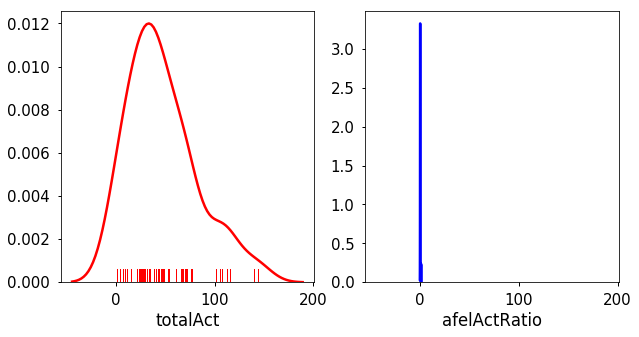

In [40]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(df_full_stats.totalAct, hist=False, rug=True, color="r", ax=axes[0])
sns.distplot(df_full_stats.afelActRatio, hist=False, rug=True, color="b", ax=axes[1])

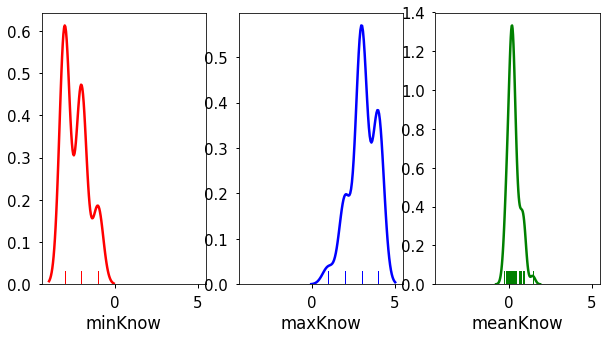

In [41]:
f, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True)
sns.distplot(df_full_stats.minKnow, hist=False, rug=True, color="r", ax=axes[0])
sns.distplot(df_full_stats.maxKnow, hist=False, rug=True, color="b", ax=axes[1])
sns.distplot(df_full_stats.meanKnow, hist=False, rug=True, color="g", ax=axes[2])

# Correlation analysis

## Normalizing stats

In [42]:
normalizer = Normalizer()

In [43]:
df_full_stats_normalised = pd.DataFrame(normalizer.transform(df_full_stats), columns=df_full_stats.columns)

## pairwise relationships between features

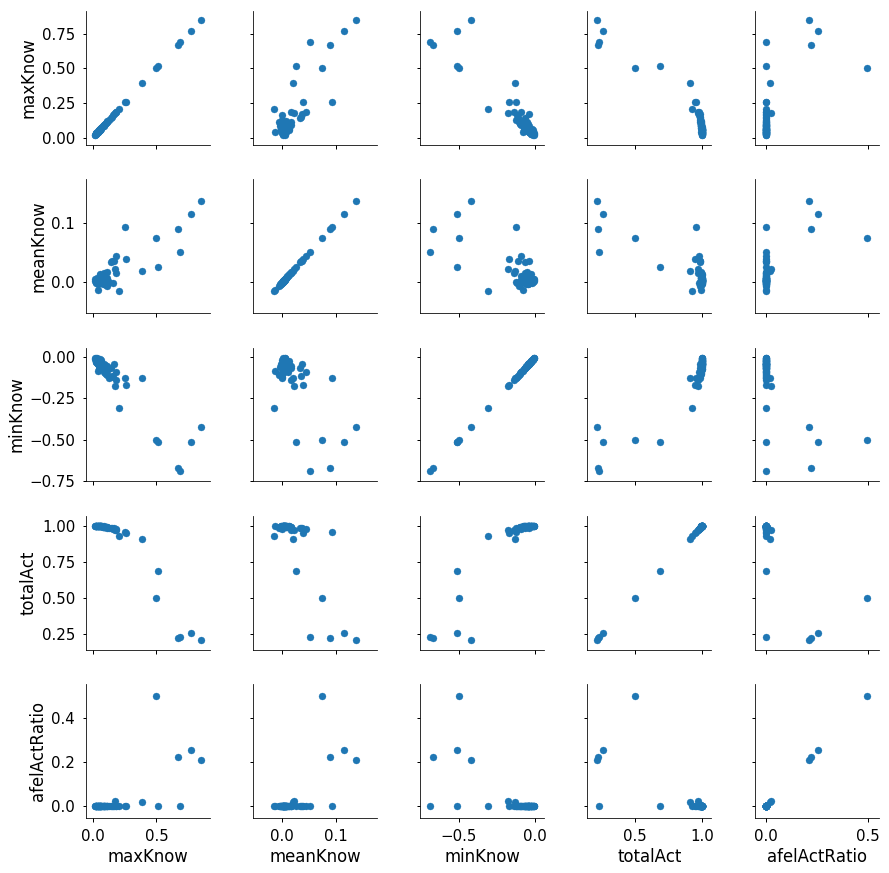

In [44]:
g = sns.PairGrid(df_full_stats_normalised)
g = g.map(plt.scatter)

## Correlation between mean knowledge accuracy and total number of actions

In [45]:
pearsonr(df_full_stats_normalised.meanKnow, df_full_stats_normalised.totalAct)

(-0.810086471995704, 1.5366778761060397e-15)

## Correlation between mean knowledge accuracy and ratio of afel actions on total number of actions

In [46]:
pearsonr(df_full_stats_normalised.meanKnow, df_full_stats_normalised.afelActRatio)

(0.6827418123675907, 9.817821836641312e-10)

WTF! Negative significative correlations, seriously?!